# Hardware lab 1 (and 2): implementing your control law / Steer by wire

In this first hardware lab we are first going to work without the passive arms of our robot and only focus on the motors. The objective of the lab is to informally play with the motor API and understand the possible issues that can  arise when trying to control accurately a motor.

Concretely, we will play with the notion of PD control (discussed in next week's lecture) and use this to reproduce a [steer-by-wire](https://en.wikipedia.org/wiki/Steer-by-wire) system. 



## Preliminaries
First, listen to Garry or Katy for the first few minutes of the lab while they provide some guidance on the platform.

## Communicating with the device
The DICE machines are connected to the platform using a CAN device. This is hidden within a high-level API but you can have a look at the code if you are interested in seeing how all of this works.

To work, open a python console, or edit a file and execute the code that follows. The CAN bus protocol does not work very with Jupyter notebooks unfortunately and keyboard interruptions won't work.



The API is presented in [AROMotorControlAPI.md](https://github.com/ediadvancedrobotics/hardwarelab/blob/main/README.md). The only methods that we need are `readPosition` and `applyTorqueToMotor`.

Each method has a `motorid` parameter, taking the value 1 or 2, which points to the motor that you wish to control.


Therefore, to read the position (joint angle value) or a motor, simply call:



In [1]:
from motor_control.AROMotorControl import AROMotorControl

mc = AROMotorControl()
mc.readPosition(motorid=1)

117.20000000001164

The returned value is an angle value in degrees, between 0 and 360.


## A torque controlled motor
The motor is controlled by sending a current command to it, which results in its rotation. The rotational force produced is called a torque (more on this during the lectures).


### Torque vs current
This paragraph is just for general knowledge. The torque generated is proportional to the current through the relationship $\tau = k I $, with $\tau$ the torque, $I$ the current (in Amperes), and k a constant given by the manufacturer. In our case, the torque constant provided by the [manufacturer](https://www.myactuator.com/product-page/rmd-l-5010) is $0.16$, which trivially gives you $I = \frac{\tau}{0.16}$. We will trust the manufacturer although this might change from a motor to the other (and is yet another source of approximation).


### Sending a command
To send current command you are required to use an exception handling mechanismthat always safely terminates by resetting the control command. Unfortunately this can't be encapsulated in a function as this results in packages loss.

The `run_until` method defined there also allows you to call N times the same method while ensuring an accurate delay `dt` expires before being called again.

Let us use `run_until` to send a constant torque of 0.02 Nm for 2 seconds



In [8]:
from template import run_until

dt = 0.005
N = int(2. / dt)


try:
    run_until(mc.applyTorqueToMotor, N=N, dt=0.005, motorid=1, torque=0.02)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyCurrentToMotor(1, 0)
    mc.applyCurrentToMotor(2, 0)
    print("motors stopped!")

motors stopped!


Lets make a simple plot of the angle value evolution over time while we are sending this command

motors stopped!


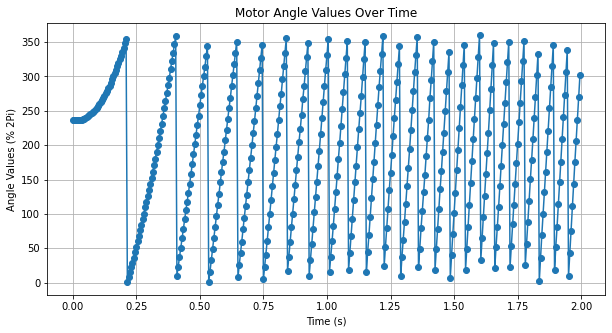

In [9]:
import matplotlib.pyplot as plt

anglevalues =[]

def store_values_and_apply_torques(motorid, torque):
    global anglevalues
    mc.applyTorqueToMotor(motorid=motorid, torque=torque)
    anglevalues+= [mc.readPosition(motorid)]
    
try:
    run_until(store_values_and_apply_torques, N=N, dt=0.005, motorid=1, torque=0.02)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyCurrentToMotor(1, 0)
    mc.applyCurrentToMotor(2, 0)
    print("motors stopped!")
    

    
time_values = [i * dt for i in range(len(anglevalues))]
    
# Plotting the angle values
plt.figure(figsize=(10, 5))
plt.plot(time_values, anglevalues, marker='o', linestyle='-')
plt.title('Motor Angle Values Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle Values (% 2Pi)')
plt.grid()
plt.show()

We can observe that as time progresses the angle values change more rapidly, which seems intuitive of course. But we are going to have to deal with these dynamic behaviours as the course progresses.

## Question 1 - Our first control law
Let us know assume that we want the motor to reach a specific angle value target.
We can start by implementing what we call a "proportional" control.
We ll measure the distance between the current position and the target position and apply a torque proportional to that distance.
For this let's create the class `PController`, for Proportional control.

It is parametrised by a $K_p$ variable that will adjust the strength of the signal sent to the motor


In [31]:
class PController:
    
    def __init__(self, Kp):
        self.Kp = Kp
                      
    def shortest_path_error(self, target, current):
        diff = ( target - current + 180 ) % 360 - 180;
        if diff < -180:
                diff = diff + 360
        if (current + diff) % 360 == target:
                return diff
        else:
                return -diff
        
    def compute(self, target, current):
        error = self.shortest_path_error(target, current)
        output = self.Kp*error
        return output
        
        

We can now define a method `goTo` for our first motor, that will apply the control law repeatidly for a given period of time

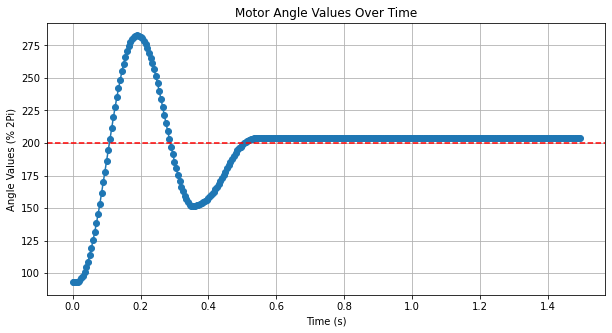

motors stopped!


In [130]:
def goTo(controller, target, time = 1., dt = 0.005, motorid =1):
    anglevalues =[]
    N = (int)(time / dt)
    
    def oneStep():
        nonlocal anglevalues
        currentAngle = mc.readPosition(motorid)
        anglevalues+=[currentAngle]
        tau = controller.compute(target,currentAngle)
        mc.applyTorqueToMotor(motorid,tau)   
        
    run_until(oneStep, N=N, dt=dt)
    
    
    time_values = [i * dt for i in range(len(anglevalues))]
    # Plotting the angle values
    plt.figure(figsize=(10, 5))
    plt.plot(time_values, anglevalues, marker='o', linestyle='-')
    plt.axhline(y=target, color='r', linestyle='--', label='Target Value')  # Add horizontal line for target
    plt.title('Motor Angle Values Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle Values (% 2Pi)')
    plt.grid()
    plt.show()
    
try:
    
    pc = PController(0.0004558)
    goTo(pc, 200, time = 1.5)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyCurrentToMotor(1, 0)
    mc.applyCurrentToMotor(2, 0)
    print("motors stopped!")
    

Experiment with different values of $K_p$.
A common issue you will encounter is overshooting, when you go beyond the desired angle and creates an oscillating behaviour:

![title](1/oscillations.png)

This can be compensated somehow by reducing $K_p$, but you then there is a risk of never reaching the target (here represented by the red line):


![title](1/miss.png)


We can try to refine our controller with a derivative gain.
The idea is that if the error is not really decreasing over time we will give a stronger signal.
If on the other end it is decreasing rapidly the signal will be weaker:


In [122]:
class PDController:
    
    def __init__(self, Kp, Kd):
        self.Kp = Kp
        self.Kd = Kd
        self.prev_error = 0
        self.first_call = True #do not compute error variation on first call
        
    
    def reset(self):
        self.first = True
                      
    def shortest_path_error(self, target, current):
        diff = ( target - current + 180 ) % 360 - 180;
        if diff < -180:
                diff = diff + 360
        if (current + diff) % 360 == target:
                return diff
        else:
                return -diff
        
    def compute(self, target, current, dt):
        error = self.shortest_path_error(target, current)        
        d_error = d_error = (error - self.prev_error) if not self.first_call else 0
        output = self.Kp*error + self.Kd * d_error / dt 
        self.first_call = False
        return output
        
        

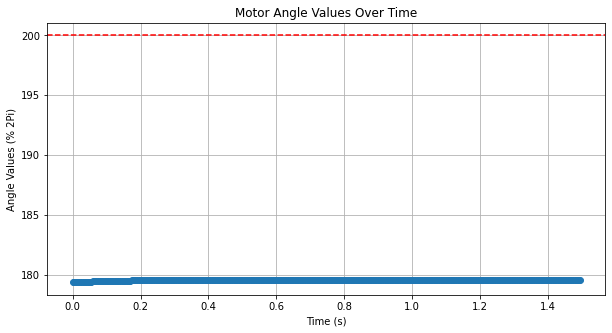

motors stopped!


In [142]:
def goTo(controller, target, time = 1., dt = 0.005, motorid =1):
    anglevalues =[]
    N = (int)(time / dt)
    
    def oneStep():
        nonlocal anglevalues
        currentAngle = mc.readPosition(motorid)
        anglevalues+=[currentAngle]
        tau = controller.compute(target,currentAngle, dt)
        mc.applyTorqueToMotor(motorid,tau)   
        
    run_until(oneStep, N=N, dt=dt)
    
    
    time_values = [i * dt for i in range(len(anglevalues))]
    # Plotting the angle values
    plt.figure(figsize=(10, 5))
    plt.plot(time_values, anglevalues, marker='o', linestyle='-')
    plt.axhline(y=target, color='r', linestyle='--', label='Target Value')  # Add horizontal line for target
    plt.title('Motor Angle Values Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle Values (% 2Pi)')
    plt.grid()
    plt.show()
    
try:
    
    pc = PDController(0.0004558,0.0000004)
    goTo(pc, 200, time = 1.5)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyCurrentToMotor(1, 0)
    mc.applyCurrentToMotor(2, 0)
    print("motors stopped!")

In [171]:
import time 
class PIDController:
    
    def __init__(self, Kp, Kd, Ki):
        self.Kp = Kp
        self.Kd = Kd
        self.Ki = Ki
        self.integral = 0
        self.prev_error = 0
        self.first_call = True #do not compute error variation on first call
        self.t = time.perf_counter() 
        
    
    def reset(self):
        self.first = True
        self.integral = 0
                      
    def shortest_path_error(self, target, current):
        diff = ( target - current + 180 ) % 360 - 180;
        if diff < -180:
                diff = diff + 360
        if (current + diff) % 360 == target:
                return diff
        else:
                return -diff
        
    def compute(self, target, current):
        tn = time.perf_counter() 
        dt = tn - self.t
        self.t = tn
        error = self.shortest_path_error(target, current)        
        d_error = d_error = (error - self.prev_error) if not self.first_call else 0
        self.integral += error * dt
        output = self.Kp*error + self.Kd * d_error / dt + self.Ki * self.integral
        self.first_call = False
        return output
        

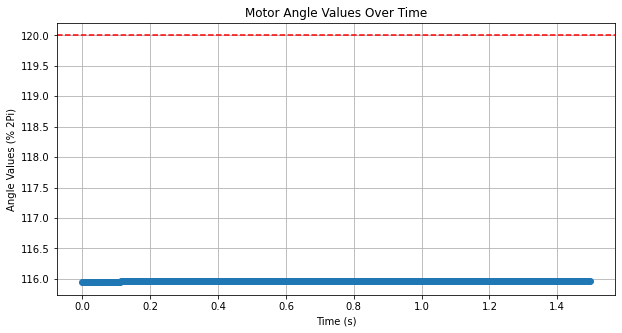

motors stopped!


In [182]:
def goTo(controller, target, time = 1., dt = 0.005, motorid =1):
    anglevalues =[]
    N = (int)(time / dt)
    
    def oneStep():
        nonlocal anglevalues
        currentAngle = mc.readPosition(motorid)
        anglevalues+=[currentAngle]
        tau = controller.compute(target,currentAngle)
        mc.applyTorqueToMotor(motorid,tau)   
        
    run_until(oneStep, N=N, dt=dt)
    
    
    time_values = [i * dt for i in range(len(anglevalues))]
    # Plotting the angle values
    plt.figure(figsize=(10, 5))
    plt.plot(time_values, anglevalues, marker='o', linestyle='-')
    plt.axhline(y=target, color='r', linestyle='--', label='Target Value')  # Add horizontal line for target
    plt.title('Motor Angle Values Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle Values (% 2Pi)')
    plt.grid()
    plt.show()
    
try:
    
    pc = PIDController(0.000458,0.000004, 0.0001)
    goTo(pc, 120, time = 1.5)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyCurrentToMotor(1, 0)
    mc.applyCurrentToMotor(2, 0)
    print("motors stopped!")




## Question 1 - Our first control law
Write a function that performs one iteration of a control loop: Given a desired position and a motor, read the current state and perform one step of PD control to bring the motor to the desired state. 
<mark>Important:</mark> Please make sure that you execute this or any other function in a try-catch block (as shown in [template.py](./template.py)) so that if for any reason you have to terminate your program, the motors stop. Otherwise the motors will continue to execute the last command applied to them.


## Question 2

Test this function within a loop and plot the obtained trajectory. Tune your P and D gains accordingly until you reach a desired behaviour. We are going to control the system at a frequency of 1 khz, which means that each tick should last 1 ms. As for the rununtil function in the lab, the control loop should have a structure like this one:

In [3]:
import time
t = time.perf_counter()
N=int(10e3) #10 seconds
dt = 1. / 1e3
wait = 1. / 1e4
for i in range(N):
    t +=dt
    #run your code
    while(time.perf_counter()-t<dt):
        pass
        time.sleep(wait)

You should of course tune your gains accordingly for the rest of the labs, but this is also the occasion to voluntarily play with the values and observe what happens when you obtain oscillatory behaviours for instance. This will become interesting in particular for the next question.

## Question 3
Now, write a 30s control loop that does the following:
+ Motor 1 is configured to track the position of motor 2
+ Motor 2 is configured to track the position of motor 1

Manually mess around with the motors while the loop is running, you should feel a haptic feedback. A similar system is implemented in some of the recent cars where the steering wheel and the wheels are no longer mechanically connected.